<a href="https://colab.research.google.com/github/elain-b/Mercedes-Benz_Greener_Manufacturing/blob/master/Mercedes_Benz_Greener_Manufacturing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bern33","key":"7d0aa53f961ad2406098ad8de3ce161d"}'}

In [7]:
!kaggle --version
!pip install kaggle --upgrade

Kaggle API 1.5.4
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [12]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c mercedes-benz-greener-manufacturing

  0% 0.00/10.7k [00:00<?, ?B/s]
100% 10.7k/10.7k [00:00<00:00, 16.4MB/s]
  0% 0.00/175k [00:00<?, ?B/s]
100% 175k/175k [00:00<00:00, 47.5MB/s]
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 47.5MB/s]


In [13]:
!unzip /content/train.csv.zip
!unzip /content/test.csv.zip
!unzip /content/sample_submission.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999

from subprocess import check_output
print(check_output(["ls", "../content"]).decode("utf8"))

kaggle.json
sample_data
sample_submission.csv
sample_submission.csv.zip
test.csv
test.csv.zip
train.csv
train.csv.zip



In [15]:
train_df = pd.read_csv("../content/train.csv")
test_df = pd.read_csv("../content/test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


In [16]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

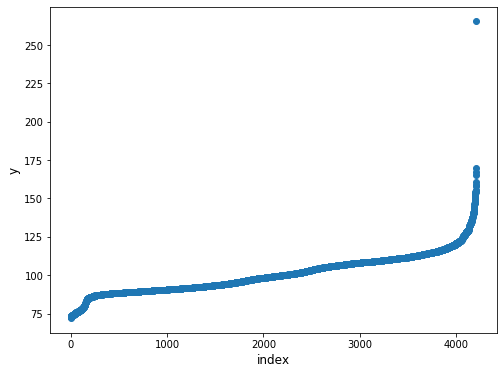

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


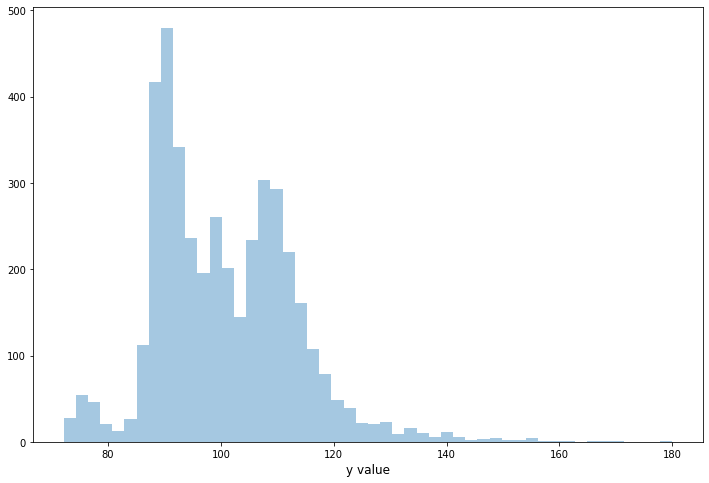

In [18]:
ulimit = 180
train_df['y'].ix[train_df['y']>ulimit] = ulimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.show()

In [19]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [20]:
dtype_df.ix[:10,:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,Count,Column Type
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


In [21]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,column_name,missing_count


In [22]:
unique_values_dict = {}
for col in train_df.columns:
    if col not in ["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        unique_value = str(np.sort(train_df[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

Columns containing the unique values :  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145'

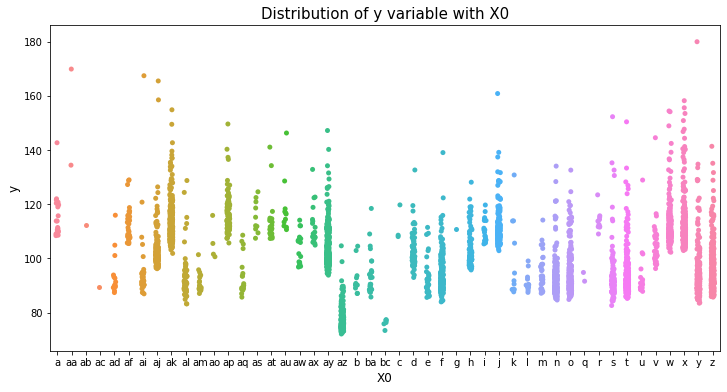

In [23]:
var_name = "X0"
col_order = np.sort(train_df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.stripplot(x=var_name, y='y', data=train_df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

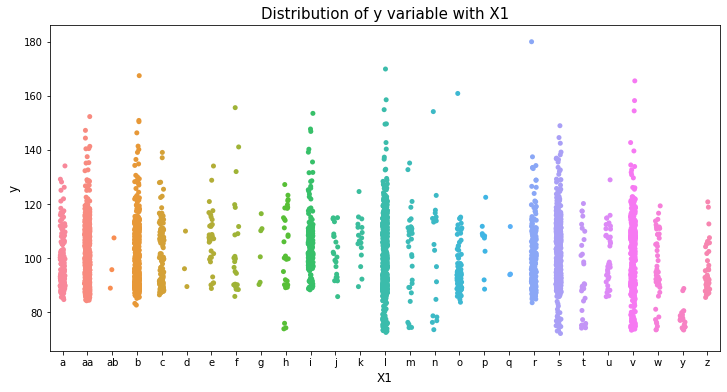

In [24]:
var_name = "X1"
col_order = np.sort(train_df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.stripplot(x=var_name, y='y', data=train_df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

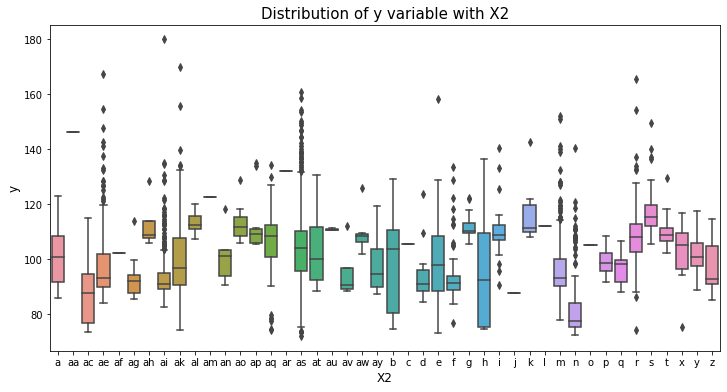

In [25]:
var_name = "X2"
col_order = np.sort(train_df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='y', data=train_df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()


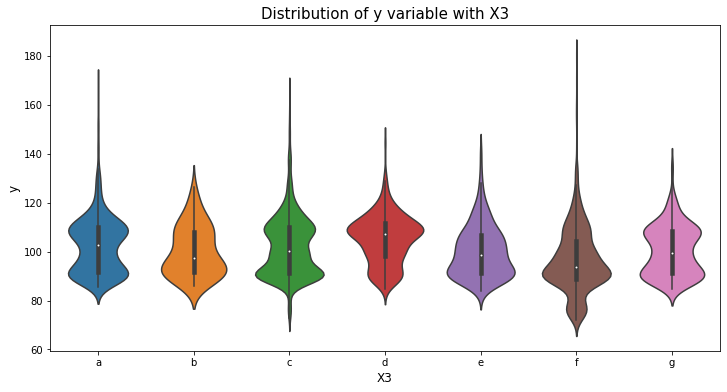

In [26]:
var_name = "X3"
col_order = np.sort(train_df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=var_name, y='y', data=train_df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

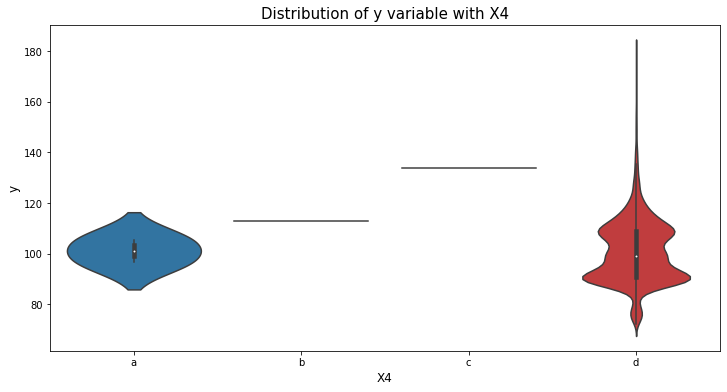

In [27]:
var_name = "X4"
col_order = np.sort(train_df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=var_name, y='y', data=train_df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

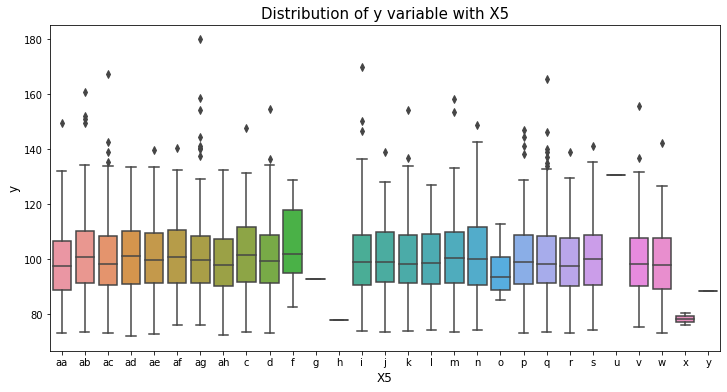

In [28]:
var_name = "X5"
col_order = np.sort(train_df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='y', data=train_df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

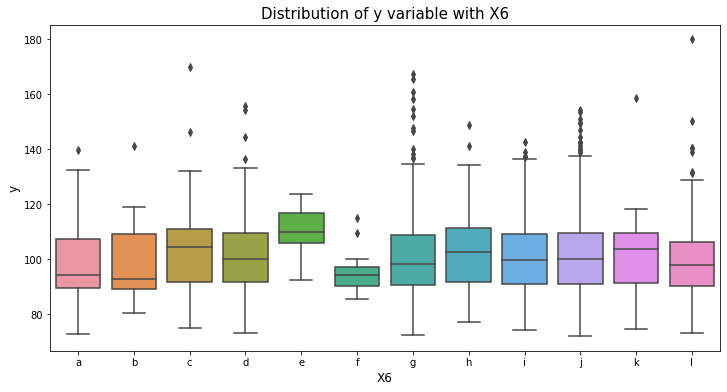

In [29]:
var_name = "X6"
col_order = np.sort(train_df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='y', data=train_df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

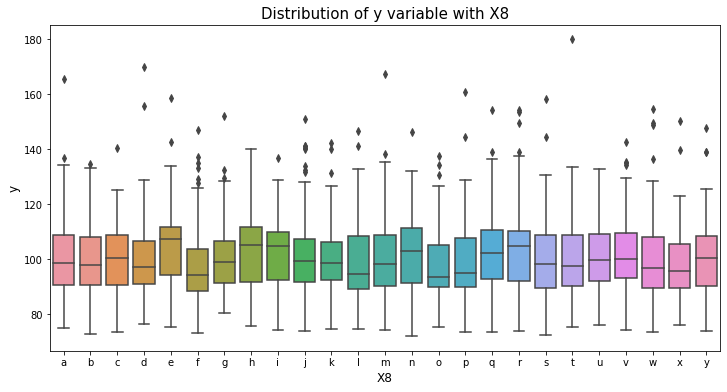

In [30]:
var_name = "X8"
col_order = np.sort(train_df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='y', data=train_df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

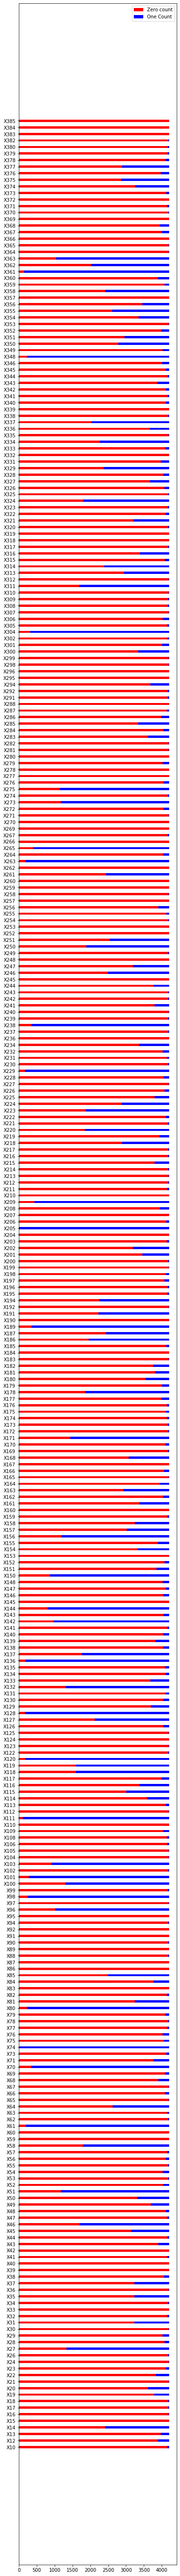

In [31]:
zero_count_list = []
one_count_list = []
cols_list = unique_values_dict['[0, 1]']
for col in cols_list:
    zero_count_list.append((train_df[col]==0).sum())
    one_count_list.append((train_df[col]==1).sum())

N = len(cols_list)
ind = np.arange(N)
width = 0.35

plt.figure(figsize=(6,100))
p1 = plt.barh(ind, zero_count_list, width, color='red')
p2 = plt.barh(ind, one_count_list, width, left=zero_count_list, color="blue")
plt.yticks(ind, cols_list)
plt.legend((p1[0], p2[0]), ('Zero count', 'One Count'))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


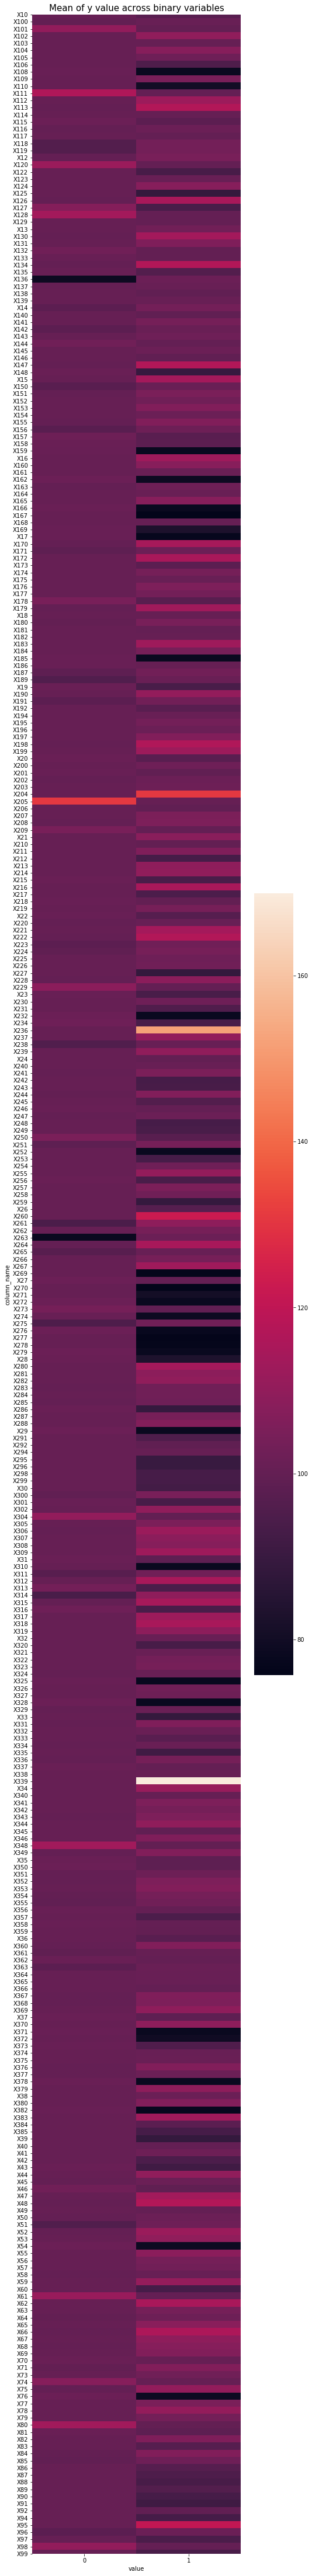

In [32]:
zero_mean_list = []
one_mean_list = []
cols_list = unique_values_dict['[0, 1]']
for col in cols_list:
    zero_mean_list.append(train_df.ix[train_df[col]==0].y.mean())
    one_mean_list.append(train_df.ix[train_df[col]==1].y.mean())

new_df = pd.DataFrame({"column_name":cols_list+cols_list, "value":[0]*len(cols_list) + [1]*len(cols_list), "y_mean":zero_mean_list+one_mean_list})
new_df = new_df.pivot('column_name', 'value', 'y_mean')

plt.figure(figsize=(8,80))
sns.heatmap(new_df)
plt.title("Mean of y value across binary variables", fontsize=15)
plt.show()

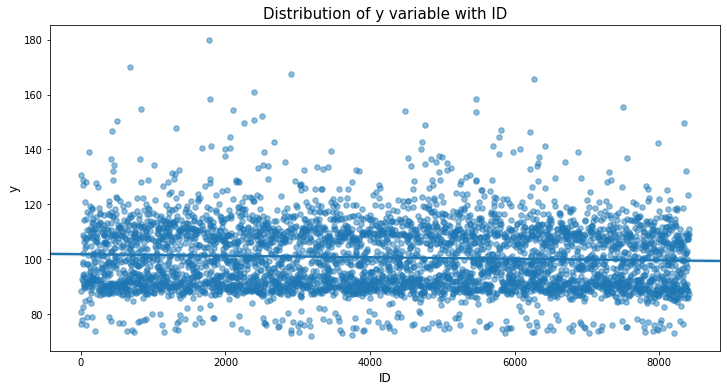

In [33]:
var_name = "ID"
plt.figure(figsize=(12,6))
sns.regplot(x=var_name, y='y', data=train_df, scatter_kws={'alpha':0.5, 's':30})
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

<Figure size 432x720 with 0 Axes>

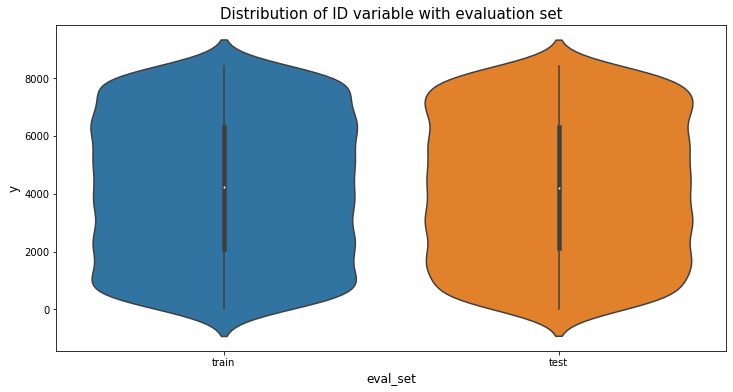

In [34]:
plt.figure(figsize=(6,10))
train_df['eval_set'] = "train"
test_df['eval_set'] = "test"
full_df = pd.concat([train_df[["ID","eval_set"]], test_df[["ID","eval_set"]]], axis=0)

plt.figure(figsize=(12,6))
sns.violinplot(x="eval_set", y='ID', data=full_df)
plt.xlabel("eval_set", fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of ID variable with evaluation set", fontsize=15)
plt.show()

[06:07:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


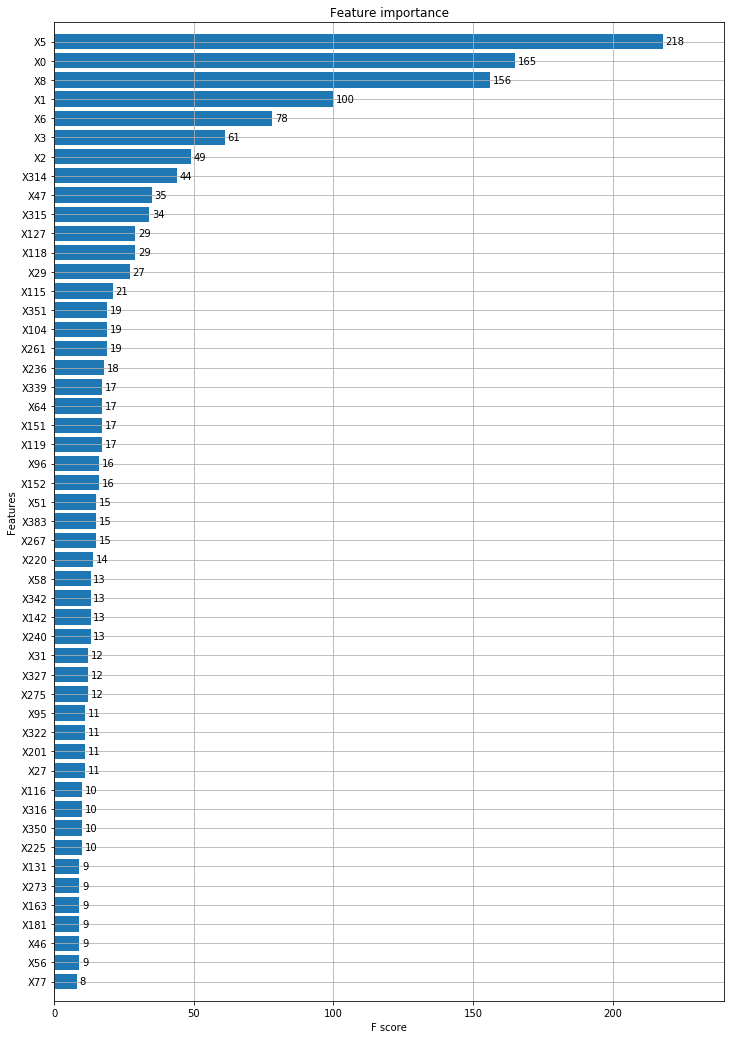

In [35]:
for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))
        
train_y = train_df['y'].values
train_X = train_df.drop(["ID", "y", "eval_set"], axis=1)

# Thanks to anokas for this #
def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100, feval=xgb_r2_score, maximize=True)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()


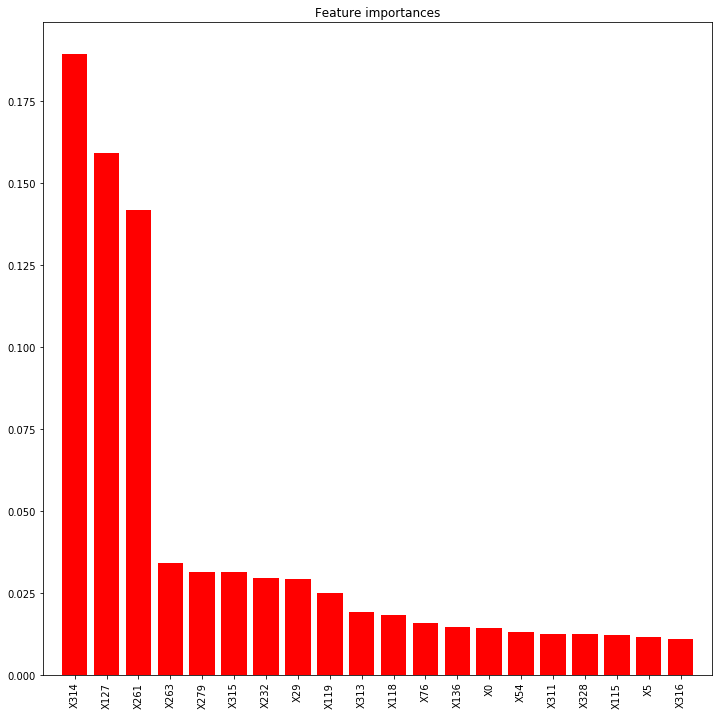

In [36]:
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)
feat_names = train_X.columns.values

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-mercedes